<a href="https://colab.research.google.com/github/XescLlabres/tfgFLM/blob/main/WDBC/RENOU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('data.csv.xls')

In [ ]:
df.drop(['Unnamed: 32','id'],axis=1,inplace=True)
df.diagnosis=[1 if each=="M" else 0 for each in df.diagnosis]

In [ ]:

# Afegir renou proporcional als valors de totes les columnes, excepte diagnosis
for columna in df.select_dtypes(include=[np.number]).columns:
    if columna != 'diagnosis':
        # Calcular el renou proporcional
        ruido = np.random.normal(0, 2*df[columna].std(), size=df[columna].shape)
        df[columna] += ruido
#Guardar el dataset amb renou
df.to_csv('dataset_con_ruido.csv', index=False)



#Entrenar model amb renou

In [ ]:
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut

df50 = pd.read_csv('dataset_con_ruido.csv')

df50.columns = df50.columns.str.strip()


y = df50.loc[:, "diagnosis"].values

X1 = df50.loc[:, (df50.columns != "diagnosis") & (df50.columns != "id")].values #Dades amb renou
df2 = pd.read_csv('data.csv.xls')
df2.drop(['Unnamed: 32','id'],axis=1,inplace=True)
df2.diagnosis=[1 if each=="M" else 0 for each in df.diagnosis]
X2 = df2.loc[:, (df2.columns != "diagnosis") & (df2.columns != "id")].values #Dades fora renou


scaler = StandardScaler()
#Escalam les dues X
X_scaled = scaler.fit_transform(X1)
X2_scaled = scaler.fit_transform(X2)

# Model i LOOCV
loo = LeaveOneOut()
model = LogisticRegression(max_iter=1000)

all_bootstrap_probabilities = []

# Aplicar LOOCV amb Bootstrap
for train_index, test_index in loo.split(X_scaled):  # Usam X escalat
    # Train amb renou, test sense renou
    X_train, X_test = X_scaled[train_index], X2_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    bootstrapped_probabilities = []

    for _ in range(500):

        X_train_bootstrap, y_train_bootstrap = resample(X_train, y_train, replace=True)

        # Entrenar el model amb les dades amb renou
        model.fit(X_train_bootstrap, y_train_bootstrap)


        prob = model.predict_proba(X_test)[:, 1][0]  # Probabilidad de clase 1
        bootstrapped_probabilities.append(prob)

    # Guardar probabilitats
    all_bootstrap_probabilities.append(bootstrapped_probabilities)

df50_probabilities = pd.DataFrame(all_bootstrap_probabilities)

#Fer taula amb id, diag i probabilitats

In [ ]:
data1 = pd.read_csv('data.csv.xls')
data1.drop(['Unnamed: 32'],axis=1,inplace=True)
df50_probabilities.insert(0, 'id', data1['id'].values)
df50_probabilities.to_csv("bootstrap_probabilities_id50.csv", index=False)

In [ ]:


taula1 = pd.read_csv('bootstrap_probabilities_id50.csv')
taula2 = pd.read_csv('data.csv.xls')
taula2.diagnosis=[1 if each=="M" else 0 for each in taula2.diagnosis]


id_column = taula1.iloc[:, 0]
probabilities = taula1.iloc[:, 1:]


taula2_processed = taula2[['id', 'diagnosis']]


id_diag_prob50 = pd.merge(taula2_processed, taula1, on='id')


print(id_diag_prob50.head())


id_diag_prob50.to_csv('id_diag_prob50.csv', index=False)

         id  diagnosis         0         1         2         3         4  \
0    842302          1  1.000000  1.000000  1.000000  1.000000  1.000000   
1    842517          1  0.997103  0.996519  0.998523  0.999608  0.998323   
2  84300903          1  0.999989  0.999997  0.999995  0.999999  0.999998   
3  84348301          1  0.996694  0.979579  0.996068  0.969410  0.994080   
4  84358402          1  0.999842  0.999227  0.999905  0.999660  0.999611   

          5         6         7  ...       490       491       492       493  \
0  0.999999  0.999999  1.000000  ...  1.000000  1.000000  1.000000  1.000000   
1  0.999624  0.999635  0.999629  ...  0.999621  0.998046  0.998553  0.999192   
2  0.999995  0.999996  0.999988  ...  0.999996  0.999998  0.999996  0.999996   
3  0.995926  0.999752  0.987371  ...  0.982906  0.999686  0.992574  0.996834   
4  0.999741  0.999957  0.999902  ...  0.999913  0.999668  0.999875  0.999956   

        494       495       496       497       498       499 

#Fer taula amb prediccions i primer analisi

In [ ]:
taula1 = pd.read_csv('bootstrap_probabilities_id50.csv')

taula2 = pd.read_csv('data.csv.xls')

taula2.drop(['Unnamed: 32'],axis=1,inplace=True)
taula2.diagnosis=[1 if each=="M" else 0 for each in taula2.diagnosis]

In [ ]:

id_column = taula1.iloc[:, 0]


probabilities = taula1.iloc[:, 1:]

#Llindar directament a 0.5
y_pred = (probabilities.mean(axis=1) >= 0.5).astype(int)


taula1_processed = pd.DataFrame({'id': id_column, 'y_pred': y_pred})

taula2_processed = taula2[['id', 'diagnosis']]
taula2_processed.rename(columns={'diagnosis': 'y_true'}, inplace=True)

taula05_50 = pd.merge(taula1_processed, taula2_processed, on='id')


print(taula05_50.head())

         id  y_pred  y_true
0    842302       1       1
1    842517       1       1
2  84300903       1       1
3  84348301       1       1
4  84358402       1       1


<ipython-input-14-45144bacc16a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taula2_processed.rename(columns={'diagnosis': 'y_true'}, inplace=True)


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

y_pred = taula05_50['y_pred']
y_true = taula05_50['y_true']

# 1. Matriu de Confusió
cm = confusion_matrix(y_true, y_pred)
print("Matriu de confusió:")
print(cm)

# 2. Precisió
precision = precision_score(y_true, y_pred)
print(f"Precisió: {precision:.2f}")

# 3. Recall
recall = recall_score(y_true, y_pred)
print(f"Recall: {recall:.2f}")

# 4. F1-Score
f1 = f1_score(y_true, y_pred)
print(f"F1-Score: {f1:.2f}")

# 5. Exactitut
accuracy = accuracy_score(y_true, y_pred)
print(f"Exactitut: {accuracy:.2f}")

Matriu de confusió:
[[349   8]
 [ 22 190]]
Precisió: 0.96
Recall: 0.90
F1-Score: 0.93
Exactitut: 0.95


#DF i formules (lo mateix amb renou .50 a tots)

In [ ]:


df = pd.read_csv('id_diag_prob50.csv')

id_column = 'id'
diagnosis_column = 'diagnosis'
prob_columns = df.columns[2:]


def calcular_intervalo(probabilidades, li, ls):
    lower_bound = np.percentile(probabilidades, li)
    upper_bound = np.percentile(probabilidades, ls)
    return lower_bound, upper_bound

In [ ]:

intervalos_confianza = []


for index, row in df.iterrows():
    probabilidades = row[prob_columns].values
    lower, upper = calcular_intervalo(probabilidades, 2.5, 97.5)
    intervalos_confianza.append([row[id_column], row[diagnosis_column], lower, upper])


df_intervalos = pd.DataFrame(intervalos_confianza, columns=[id_column, diagnosis_column, 'lower_bound', 'upper_bound'])


print(df_intervalos.tail())

           id  diagnosis   lower_bound  upper_bound
564  926424.0        1.0  9.999981e-01     1.000000
565  926682.0        1.0  9.992558e-01     0.999990
566  926954.0        1.0  8.904370e-01     0.990138
567  927241.0        1.0  9.999999e-01     1.000000
568   92751.0        0.0  1.534816e-07     0.000040


In [ ]:
def calcular_TP(a, b):
    TP = min(1 - a, b)
    return TP
def calcular_AP(a,b):
    AP = min(a, 1-b)
    return AP
def calcular_EP(a,b):
    EP = (b-a)
    return EP

In [ ]:

df_intervalos['TP'] = df_intervalos.apply(lambda row: calcular_TP(row['lower_bound'], row['upper_bound']), axis=1)

df_intervalos['AP'] = df_intervalos.apply(lambda row: calcular_AP(row['lower_bound'], row['upper_bound']), axis=1)

df_intervalos['EP'] = df_intervalos.apply(lambda row: calcular_EP(row['lower_bound'], row['upper_bound']), axis=1)


print(df_intervalos.head())

           id  diagnosis  lower_bound  upper_bound        TP            AP  \
0    842302.0        1.0     0.999998     1.000000  0.000002  6.171648e-10   
1    842517.0        1.0     0.995649     0.999893  0.004351  1.067632e-04   
2  84300903.0        1.0     0.999972     1.000000  0.000028  2.520786e-07   
3  84348301.0        1.0     0.950100     0.999969  0.049900  3.052899e-05   
4  84358402.0        1.0     0.999171     0.999992  0.000829  7.915100e-06   

         EP  
0  0.000002  
1  0.004245  
2  0.000027  
3  0.049869  
4  0.000821  


#Analisi TP, EP i AP amb renou 0.50 a tot

In [ ]:
# Mitjanes
medias = df_intervalos[['TP', 'AP', 'EP']].mean()
print("Mitjanes:")
print(medias)

# Valor màxim
fila_max_TP = df_intervalos.loc[df_intervalos['TP'].idxmax()]
print("\nFila amb el valor màxim de TP:")
print(fila_max_TP)

# Valor mínim
fila_min_TP = df_intervalos.loc[df_intervalos['TP'].idxmin()]
print("\nFila amb el valor mínim de TP:")
print(fila_min_TP)

# Medida de dispersión (opcional): desviación estándar
desviacion = df_intervalos[['TP', 'AP', 'EP']].std()
print("\nDesviacions estàndar:")
print(desviacion)

Mitjanes:
TP    0.096692
AP    0.017202
EP    0.079491
dtype: float64

Fila amb el valor màxim de TP:
id             859471.000000
diagnosis           0.000000
lower_bound         0.010304
upper_bound         0.987101
TP                  0.987101
AP                  0.010304
EP                  0.976798
Name: 68, dtype: float64

Fila amb el valor mínim de TP:
id             9.112962e+08
diagnosis      1.000000e+00
lower_bound    1.000000e+00
upper_bound    1.000000e+00
TP             2.764455e-14
AP             0.000000e+00
EP             2.764455e-14
Name: 461, dtype: float64

Desviacions estàndar:
TP    0.190319
AP    0.047264
EP    0.154642
dtype: float64


In [ ]:
# Calcular correlació entre TP, AP i EP
correlaciones = df_intervalos[['TP', 'AP', 'EP']].corr()
print("\nCorrelacions entre TP, AP i EP:")
print(correlaciones)


Correlacions entre TP, AP i EP:
          TP        AP        EP
TP  1.000000  0.808264  0.983673
AP  0.808264  1.000000  0.689102
EP  0.983673  0.689102  1.000000


In [ ]:
# Comparar las medias de TP, AP y EP según diagnosis
medias_por_diagnostico = df_intervalos.groupby('diagnosis')[['TP', 'AP', 'EP']].mean()
print("\Mitjanes de TP, AP i EP por diagnosis:")
print(medias_por_diagnostico)

\Mitjanes de TP, AP i EP por diagnosis:
                 TP        AP        EP
diagnosis                              
0.0        0.082792  0.012657  0.070135
1.0        0.120100  0.024854  0.095246


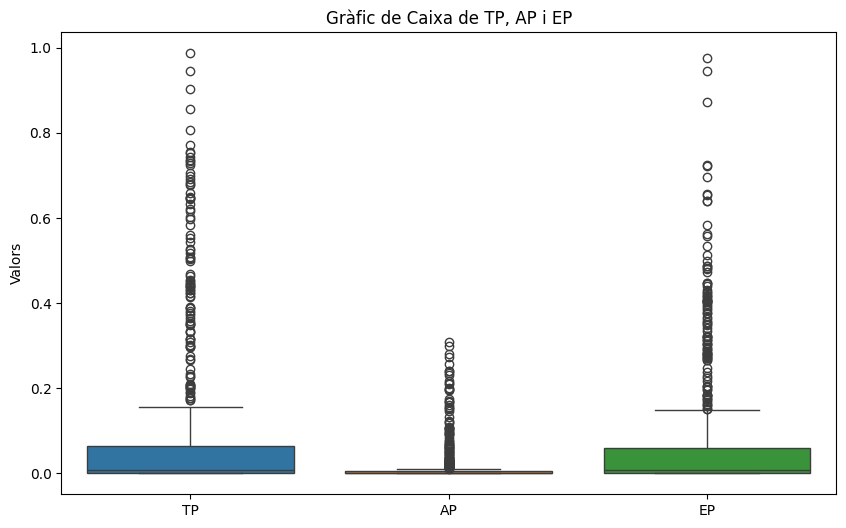

In [ ]:
import seaborn as sns

# Crear un gràfic de caixa per TP, AP i EP
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_intervalos[['TP', 'AP', 'EP']])
plt.title('Gràfic de Caixa de TP, AP i EP')
plt.ylabel('Valors')
plt.xticks(ticks=[0, 1, 2], labels=['TP', 'AP', 'EP'])
plt.show()


# Filtratje de dades (TP>0.1)

In [ ]:

df_filtrado = df_intervalos[df_intervalos['TP'] > 0.1]

print("Datos con TP > 0.1:")
print(df_filtrado.head())


print("\nEstadístiques descriptives per TP > 0.1:")
print(df_filtrado[['TP', 'AP', 'EP']].describe())

Datos con TP > 0.1:
            id  diagnosis  lower_bound  upper_bound        TP        AP  \
5     843786.0        1.0     0.664642     0.979395  0.335358  0.020605   
7   84458202.0        1.0     0.772446     0.969684  0.227554  0.030316   
10    845636.0        1.0     0.145932     0.632045  0.632045  0.145932   
13    846381.0        1.0     0.308542     0.787744  0.691458  0.212256   
16    848406.0        1.0     0.634972     0.906985  0.365028  0.093015   

          EP  
5   0.314753  
7   0.197238  
10  0.486113  
13  0.479202  
16  0.272013  

Estadístiques descriptives per TP > 0.1:
               TP          AP          EP
count  128.000000  128.000000  128.000000
mean     0.387819    0.073166    0.314653
std      0.224850    0.076831    0.184477
min      0.101596    0.000242    0.082894
25%      0.187734    0.017122    0.162786
50%      0.355415    0.037203    0.292003
75%      0.546184    0.105370    0.408238
max      0.987101    0.307711    0.976798


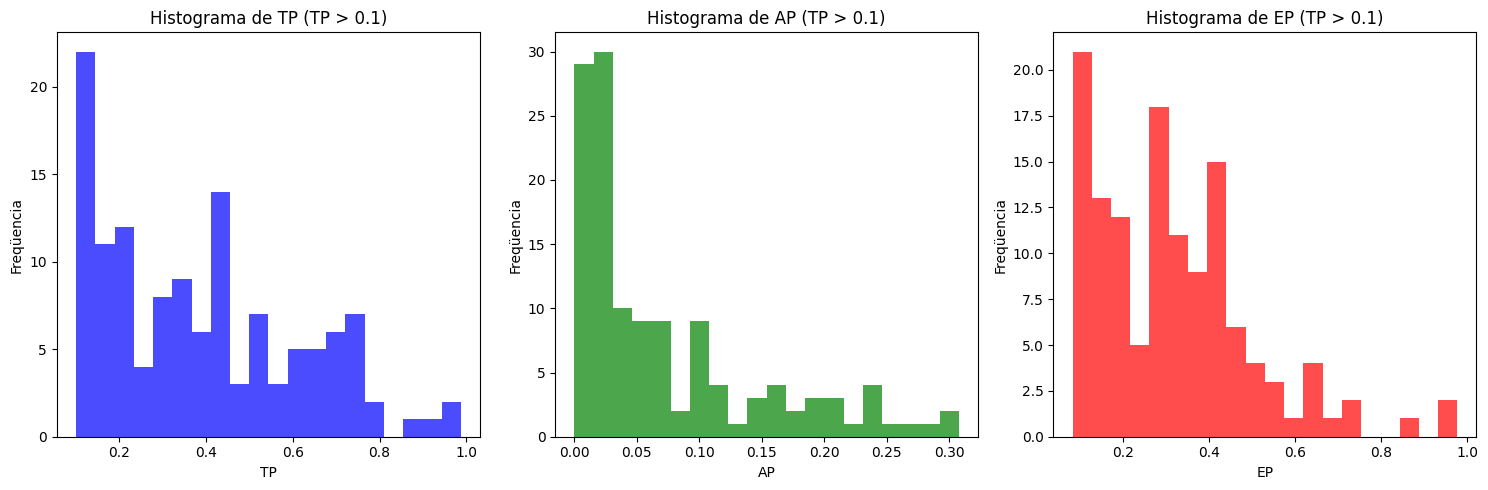

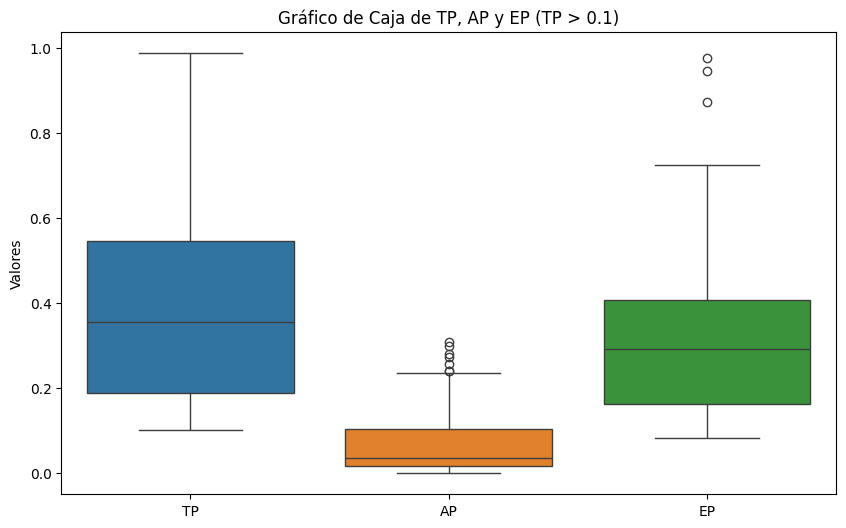

In [ ]:
#Histogrames
plt.figure(figsize=(15, 5))


plt.subplot(1, 3, 1)
plt.hist(df_filtrado['TP'], bins=20, color='blue', alpha=0.7)
plt.title('Histograma de TP (TP > 0.1)')
plt.xlabel('TP')
plt.ylabel('Freqüencia')

plt.subplot(1, 3, 2)
plt.hist(df_filtrado['AP'], bins=20, color='green', alpha=0.7)
plt.title('Histograma de AP (TP > 0.1)')
plt.xlabel('AP')
plt.ylabel('Freqüencia')

plt.subplot(1, 3, 3)
plt.hist(df_filtrado['EP'], bins=20, color='red', alpha=0.7)
plt.title('Histograma de EP (TP > 0.1)')
plt.xlabel('EP')
plt.ylabel('Freqüencia')

plt.tight_layout()
plt.show()

# Gràfic de caixa per TP, AP i EP
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtrado[['TP', 'AP', 'EP']])
plt.title('Gráfico de Caja de TP, AP y EP (TP > 0.1)')
plt.ylabel('Valores')
plt.xticks(ticks=[0, 1, 2], labels=['TP', 'AP', 'EP'])
plt.show()